In [1]:
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ahmedayman911","key":"0fbab47277901d937c4da98c2d72c6ef"}'}

In [6]:
!kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset

Dataset URL: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset
License(s): CC0-1.0
 91% 135M/149M [00:00<00:00, 222MB/s]
100% 149M/149M [00:00<00:00, 224MB/s]


In [7]:
!unzip brain-tumor-mri-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: Training/glioma/Tr-gl_0712.jpg  
  inflating: Training/glioma/Tr-gl_0713.jpg  
  inflating: Training/glioma/Tr-gl_0714.jpg  
  inflating: Training/glioma/Tr-gl_0715.jpg  
  inflating: Training/glioma/Tr-gl_0716.jpg  
  inflating: Training/glioma/Tr-gl_0717.jpg  
  inflating: Training/glioma/Tr-gl_0718.jpg  
  inflating: Training/glioma/Tr-gl_0719.jpg  
  inflating: Training/glioma/Tr-gl_0720.jpg  
  inflating: Training/glioma/Tr-gl_0721.jpg  
  inflating: Training/glioma/Tr-gl_0722.jpg  
  inflating: Training/glioma/Tr-gl_0723.jpg  
  inflating: Training/glioma/Tr-gl_0724.jpg  
  inflating: Training/glioma/Tr-gl_0725.jpg  
  inflating: Training/glioma/Tr-gl_0726.jpg  
  inflating: Training/glioma/Tr-gl_0727.jpg  
  inflating: Training/glioma/Tr-gl_0728.jpg  
  inflating: Training/glioma/Tr-gl_0729.jpg  
  inflating: Training/glioma/Tr-gl_0730.jpg  
  inflating: Training/glioma/Tr-gl_0731.jpg  
  inflating: Training/glioma/

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import os
import glob as gb
import cv2
import tensorflow  as tf
import keras
from tqdm import tqdm
from collections import Counter
from tensorflow.keras import layers, Model
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score,precision_score, recall_score, f1_score
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.data import AUTOTUNE
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt

In [11]:
#Data Path
height=128
width=128
color_channels=3
image_size = (width, height, color_channels)
num_classes = 4  # Adjust based on your specific dataset
train_path='/content/Training'
test_path='/content/Testing'
checkpoint_path = "training_1/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
final_model_path = '/content/training_1'

In [12]:
def read_images_from_directory(folder_path, desc):
    """
    Analyzes the sizes of JPEG images within each subfolder of the given directory.

    Parameters:
    - train_path: str. The path to the directory containing subfolders of images.
    - desc: str. A description for the tqdm progress bar.

    Returns:
    - A pandas Series object with the counts of each unique image size.
    """
    images = []
    labels=[]

    # Iterate through each folder in the given directory with a progress bar

    for folder in os.listdir(folder_path):
        files = gb.glob(pathname=str(folder_path + '/' + folder + '/*.jpg'))

        # For each file in the current folder, read the image and append its size
        for file in tqdm(files, desc=desc+" in "+folder):
            image = plt.imread(file)
            img_resized=cv2.resize(image,(width,height))
            img_rgb = cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
            images.append(img_rgb)
            labels.append(folder)


    # Count the occurrence of each unique size
    return images,labels


In [13]:
x_train,y_train= read_images_from_directory(train_path, "Loading Training Data")
x_test,y_test= read_images_from_directory(test_path, "Loading Testing Data")

Loading Testing Data in glioma: 100%|██████████| 300/300 [00:00<00:00, 871.52it/s]


In [14]:
x_train = np.array(x_train) / 255.0
x_test = np.array(x_test) / 255.0


label_encoder = LabelEncoder()

# Fit the label encoder on the training labels and transform both training and test labels
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

y_train = np.array(y_train_encoded)
y_test = np.array(y_test_encoded)

print(f'X_train shape  is {x_train.shape}')
print(f'X_test shape  is {x_test.shape}')
print(f'y_train shape  is {y_train.shape}')
print(f'y_test shape  is {y_test.shape}')

X_train shape  is (5712, 128, 128, 3)
X_test shape  is (1311, 128, 128, 3)
y_train shape  is (5712,)
y_test shape  is (1311,)


In [15]:
# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Fit the label encoder and return encoded labels
y_train_encoded = np.array(label_encoder.fit_transform(y_train))
y_test_encoded = np.array(label_encoder.transform(y_test))

In [16]:
import os
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical


# One-Hot Encoding
y_train_encoded = to_categorical(y_train, num_classes=num_classes)
y_test_encoded = to_categorical(y_test, num_classes=num_classes)

def create_nasnetmobile(image_size, num_classes):
    base_model = tf.keras.applications.NASNetMobile(
        include_top=False,
        weights='imagenet',
        input_shape=image_size[:2] + (3,)
    )

    # Freeze layers in the base model
    for layer in base_model.layers:
        layer.trainable = False

    # Create a sequential model
    model = tf.keras.Sequential()

    # Add the base model
    model.add(base_model)

    # Add a global average pooling layer
    model.add(layers.GlobalAveragePooling2D())

    # Add a dense layer
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dense(num_classes, activation='softmax'))

    # Adjust trainable layers
    for layer in base_model.layers[:-10]:
        layer.trainable = False
    for layer in base_model.layers[-10:]:
        layer.trainable = True

    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Print model summary
    model.summary()

    return model

# Create data pipelines using tf.data.Dataset
def create_dataset(X, y, batch_size=32, is_training=True):
    dataset = tf.data.Dataset.from_tensor_slices((X, y))
    if is_training:
        dataset = dataset.shuffle(buffer_size=10000)
        # Apply data augmentation
        dataset = dataset.map(lambda x, y: (tf.image.random_flip_left_right(x), y),
                              num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return dataset

# Create datasets
batch_size = 16  # Further reduced batch size to lower memory usage
train_dataset = create_dataset(x_train, y_train_encoded, batch_size=batch_size, is_training=True)
test_dataset = create_dataset(x_test, y_test_encoded, batch_size=batch_size, is_training=False)

# Enable mixed precision training if supported
if tf.config.experimental.list_physical_devices('GPU'):
    from tensorflow.keras import mixed_precision
    mixed_precision.set_global_policy('mixed_float16')

# Create the model
model = create_nasnetmobile(image_size, num_classes)

# Train the model
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=test_dataset
)

# Save the final model
final_model_path = '/content/training_1'
model.save(final_model_path)


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 NASNet (Functional)         (None, 4, 4, 1056)        4269716   
                                                                 
 global_average_pooling2d_1  (None, 1056)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_2 (Dense)             (None, 256)               270592    
                                                                 
 dense_3 (Dense)             (None, 4)                 1028      
                                                                 
Total params: 4541336 (17.32 MB)
Trainable params: 271972 (1.04 MB)
Non-trainable params: 4269364 (16.29 MB)
_________________________________________________________________
Epoch 1/10
357/357 [==============================] - 41s 57ms/step - loss: 0

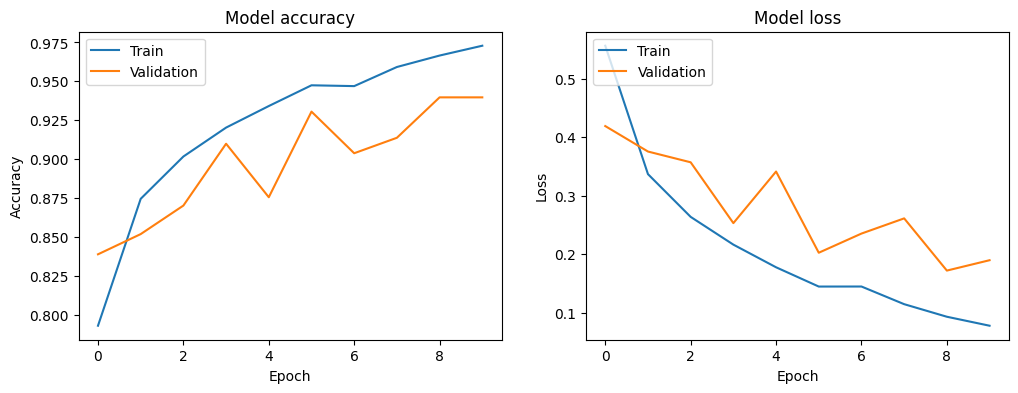

In [18]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, recall_score, f1_score
import seaborn as sns
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [19]:
from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix, classification_report
import numpy as np

# Make predictions on the test set
y_pred = model.predict(test_dataset)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test_encoded, axis=1)

# Calculate accuracy
accuracy = accuracy_score(y_true, y_pred_classes)
print(f"Accuracy: {accuracy:.4f}")

# Calculate recall for each class
recall = recall_score(y_true, y_pred_classes, average=None)
print(f"Recall for each class: {recall}")

# Calculate F1 score for each class
f1 = f1_score(y_true, y_pred_classes, average=None)
print(f"F1 Score for each class: {f1}")

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)
print("Confusion Matrix:")
print(conf_matrix)

# Print classification report for detailed metrics
class_report = classification_report(y_true, y_pred_classes)
print("Classification Report:")
print(class_report)


82/82 [==============================] - 4s 46ms/step
Accuracy: 0.9397
Recall for each class: [0.81       0.95098039 1.         0.97666667]
F1 Score for each class: [0.89174312 0.89814815 0.98901099 0.96065574]
Confusion Matrix:
[[243  47   4   6]
 [  2 291   2  11]
 [  0   0 405   0]
 [  0   4   3 293]]
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.81      0.89       300
           1       0.85      0.95      0.90       306
           2       0.98      1.00      0.99       405
           3       0.95      0.98      0.96       300

    accuracy                           0.94      1311
   macro avg       0.94      0.93      0.93      1311
weighted avg       0.94      0.94      0.94      1311



In [20]:
model.save('/content/drive/MyDrive/NASNetMobile')